In [7]:
import random
import time
import matplotlib.pyplot as plt

In [8]:
courses = ["C1", "C2", "C3", "C4", "C5"]
teachers = ["T1", "T2", "T3"]
rooms = ["R1", "R2", "R3"]
timeslots = ["S1", "S2", "S3", "S4"]

eligible_teachers = {
    "C1": ["T1", "T2"],
    "C2": ["T2"],
    "C3": ["T1", "T3"],
    "C4": ["T3"],
    "C5": ["T1", "T2", "T3"]
}

In [9]:
def is_valid(assignment, course, value):
    teacher, room, slot = value
    for c, (t, r, s) in assignment.items():
        if t == teacher and s == slot:
            return False
        if r == room and s == slot:
            return False
    return True

def get_domain(course):
    domain = []
    for t in eligible_teachers[course]:
        for r in rooms:
            for s in timeslots:
                domain.append((t, r, s))
    return domain

In [4]:
def backtrack_with_heuristics(assignment, domains, backtracks):
    if len(assignment) == len(courses):
        return assignment, backtracks

    # MRV heuristic
    unassigned = [c for c in courses if c not in assignment]
    course = min(unassigned, key=lambda c: len(domains[c]))

    # LCV heuristic
    domain = sorted(domains[course], key=lambda val: sum(is_valid(assignment, c, val) for c in unassigned))

    for value in domain:
        if is_valid(assignment, course, value):
            assignment[course] = value
            result, backtracks = backtrack_with_heuristics(assignment, domains, backtracks)
            if result:
                return result, backtracks
            del assignment[course]
        backtracks += 1
    return None, backtracks

In [10]:
def forward_check(domains, course, value):
    new_domains = {c: d.copy() for c, d in domains.items()}
    teacher, room, slot = value
    for c in new_domains:
        new_domains[c] = [v for v in new_domains[c] if not (
            v[0] == teacher and v[2] == slot or
            v[1] == room and v[2] == slot
        )]
        if not new_domains[c]:
            return None
    return new_domains

def backtrack_forward_check(assignment, domains, backtracks):
    if len(assignment) == len(courses):
        return assignment, backtracks

    unassigned = [c for c in courses if c not in assignment]
    course = min(unassigned, key=lambda c: len(domains[c]))

    for value in domains[course]:
        if is_valid(assignment, course, value):
            assignment[course] = value
            new_domains = forward_check(domains, course, value)
            if new_domains:
                result, backtracks = backtrack_forward_check(assignment, new_domains, backtracks)
                if result:
                    return result, backtracks
            del assignment[course]
        backtracks += 1
    return None, backtracks

Average Results: {'Heuristic': {'backtracks': 37.0, 'runtime': 0.18357038497924805}, 'ForwardCheck': {'backtracks': 0.0, 'runtime': 0.05373954772949219}}


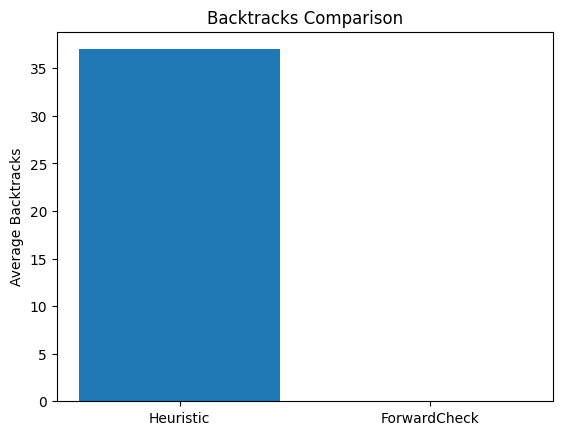

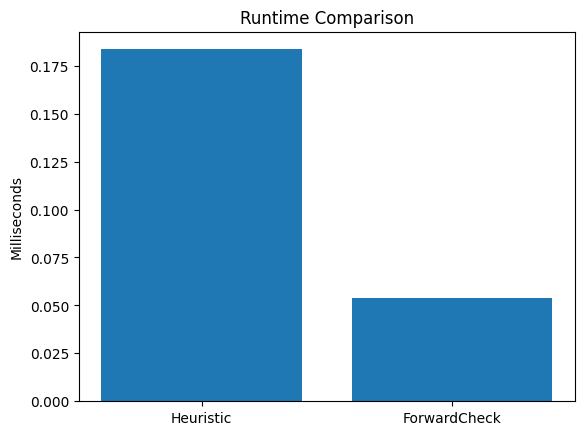

In [11]:
def run_experiments(runs=20):
    metrics = {"Heuristic": [], "ForwardCheck": []}
    for _ in range(runs):
        domains = {c: get_domain(c) for c in courses}

        start = time.time()
        _, b1 = backtrack_with_heuristics({}, domains, 0)
        t1 = (time.time() - start) * 1000
        metrics["Heuristic"].append((b1, t1))

        start = time.time()
        _, b2 = backtrack_forward_check({}, domains, 0)
        t2 = (time.time() - start) * 1000
        metrics["ForwardCheck"].append((b2, t2))
    return metrics

results = run_experiments(20)

avg = {}
for k, v in results.items():
    avg[k] = {
        "backtracks": sum(x[0] for x in v) / len(v),
        "runtime": sum(x[1] for x in v) / len(v)
    }

print("Average Results:", avg)

labels = list(avg.keys())
backtracks = [avg[k]["backtracks"] for k in labels]
runtimes = [avg[k]["runtime"] for k in labels]

plt.figure()
plt.bar(labels, backtracks)
plt.title("Backtracks Comparison")
plt.ylabel("Average Backtracks")

plt.figure()
plt.bar(labels, runtimes)
plt.title("Runtime Comparison")
plt.ylabel("Milliseconds")

plt.show()